<a href="https://colab.research.google.com/github/prog815/abscur_prediction/blob/master/20_ABS_5_1_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%A1%D0%BB%D0%B5%D0%B4%D0%98%D0%B7%D0%BC%D0%93%D0%BB%D1%83%D0%B1%D0%A1%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Прогноз следующего изменения (глубокая сеть)**

**Абсолютный курс**

Енин А.В.

г. Оренбург

25.04.2020 г.

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте -  https://vk.com/abscur

Одноклассники -  https://ok.ru/group/53547043520717

FB -  https://www.facebook.com/abscur 

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur_prediction

WhatsUp - https://chat.whatsapp.com/KrNJXAKizPxDlDSjYfdpQs

Viber - https://invite.viber.com/?g2=AQB63y7Cm%2BNJK0tNZW%2F9kI00M6Wr8HuZ7XeamzN4jZCve8Aq9%2FiD3DY56Eqcf7dc

## Альбом

# Библиотеки

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Импорт данных

Таблица с историей абсолютных курсов: https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/edit#gid=422799220

In [0]:
! wget -O abscur.py https://github.com/prog815/abscur_prediction/raw/master/abscur.py 
import abscur

--2020-04-30 08:34:11--  https://github.com/prog815/abscur_prediction/raw/master/abscur.py
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/prog815/abscur_prediction/master/abscur.py [following]
--2020-04-30 08:34:12--  https://raw.githubusercontent.com/prog815/abscur_prediction/master/abscur.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727 [text/plain]
Saving to: ‘abscur.py’

abscur.py           100%[===================>]     727  --.-KB/s    in 0s      

2020-04-30 08:34:12 (33.2 MB/s) - ‘abscur.py’ saved [727/727]



In [0]:
import sys
if 'abscur' in sys.modules:
    del sys.modules['abscur']
import abscur

In [0]:
data = abscur.get_data()
d_data = data.pct_change()

# Подготовка данных для модели

## Входы

In [0]:
glub = 30 # глубина линии задержки
cur_names = list(data.columns)
inp_names = []
inp_grups = []
for cur in cur_names:
    grup = []
    for n in range(1,glub+1):
        name = 'inp_' + cur + '_' + str(n)
        inp_names.append(name)
        grup.append(name)
        d_data[name] = d_data[cur].shift(n)
    inp_grups.append(grup)

## Выход

In [0]:
out_cur = np.random.choice(cur_names)
print('прогнозная валюта - ',out_cur)
out_name = 'out_' + cur
d_data[out_name] = np.array(d_data[out_cur]>0,dtype=int)

прогнозная валюта -  brl


## Чистим пустоты

In [0]:
d_data.dropna(inplace=True)
d_data.shape

(1289, 1396)

## Разделяем выборки (индексами)

In [0]:
all_len = d_data.shape[0]
train_len = int(all_len * 0.7)
test_len = all_len - train_len
ind_all = list(range(all_len))
ind_train = ind_all[:train_len]
ind_test = ind_all[train_len:]

## Нормировка и кодирование

In [0]:
X_train = d_data[inp_names].values[ind_train]
y_train = d_data[out_name].values[ind_train].reshape(-1,1)
X_test = d_data[inp_names].values[ind_test]
y_test = d_data[out_name].values[ind_test].reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder, StandardScaler

ss = StandardScaler()
ss.fit(X_train)

enc = OneHotEncoder(sparse=False)
enc.fit(y_train)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

# Сеть

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-rc3


## Создание модели

In [0]:
regul = 1e-1
dropout = 0.3
lr = 1e-2

model = keras.Sequential()
model.add(keras.layers.Dense(800,
                             input_shape=(X_train.shape[1],),
                             activation='relu',
                             kernel_regularizer=keras.regularizers.l2(regul)))
model.add(keras.layers.Dropout(dropout))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(800,
                             activation='relu',
                             kernel_regularizer=keras.regularizers.l2(regul)))
model.add(keras.layers.Dropout(dropout))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2,activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 800)               1080800   
_________________________________________________________________
dropout_50 (Dropout)         (None, 800)               0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 800)               3200      
_________________________________________________________________
dense_76 (Dense)             (None, 800)               640800    
_________________________________________________________________
dropout_51 (Dropout)         (None, 800)               0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 800)               3200      
_________________________________________________________________
dense_77 (Dense)             (None, 2)               

## Обучение

In [0]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=50,mode='max',restore_best_weights=True)

hist = model.fit(ss.transform(X_train),enc.transform(y_train),
          validation_split=0.2,epochs=300,callbacks=[es_callback])

print(model.evaluate(ss.transform(X_test),enc.transform(y_test)))

Epoch 1/300
23/23 [==============================] - 0s 16ms/step - loss: 69.5645 - accuracy: 0.4965 - val_loss: 35.4764 - val_accuracy: 0.4862
Epoch 2/300
23/23 [==============================] - 0s 9ms/step - loss: 32.0339 - accuracy: 0.4813 - val_loss: 27.4779 - val_accuracy: 0.5138
Epoch 3/300
23/23 [==============================] - 0s 9ms/step - loss: 22.2640 - accuracy: 0.5562 - val_loss: 22.8926 - val_accuracy: 0.4199
Epoch 4/300
23/23 [==============================] - 0s 9ms/step - loss: 20.0497 - accuracy: 0.5354 - val_loss: 19.2100 - val_accuracy: 0.4917
Epoch 5/300
23/23 [==============================] - 0s 8ms/step - loss: 18.5577 - accuracy: 0.5160 - val_loss: 18.7171 - val_accuracy: 0.4641
Epoch 6/300
23/23 [==============================] - 0s 9ms/step - loss: 17.7146 - accuracy: 0.5368 - val_loss: 17.2678 - val_accuracy: 0.5138
Epoch 7/300
23/23 [==============================] - 0s 9ms/step - loss: 15.3474 - accuracy: 0.5395 - val_loss: 16.3072 - val_accuracy: 0.530

## Графики обучения

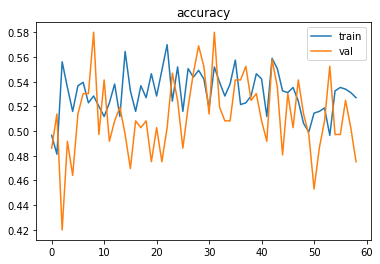

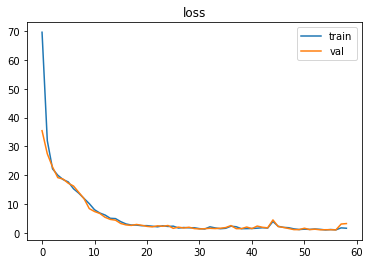

In [0]:
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='val')
plt.title('loss')
plt.legend()
plt.show()

# Расчет по модели

In [0]:
pred_train = enc.inverse_transform(model.predict(ss.transform(X_train)))
pred_test = enc.inverse_transform(model.predict(ss.transform(X_test)))

# Результаты эксперимента

In [0]:
from sklearn.metrics import *

print('----------- train report -----------')
print(classification_report(y_train,pred_train))

print('----------- test report -----------')
print(classification_report(y_test,pred_test))

----------- train report -----------
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       464
           1       0.57      0.51      0.54       438

    accuracy                           0.58       902
   macro avg       0.57      0.57      0.57       902
weighted avg       0.57      0.58      0.57       902

----------- test report -----------
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       215
           1       0.47      0.30      0.37       172

    accuracy                           0.54       387
   macro avg       0.52      0.51      0.50       387
weighted avg       0.52      0.54      0.52       387

